In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import jarque_bera
#from statsmodels.tts.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')

def generate_descriptive_statistics(df_prices, crypto_list, stock_list):

    # Calculate returns
    returns = df_prices.pct_change().dropna()
    
    print("="*80)
    print("DESCRIPTIVE STATISTICS FOR METHODOLOGY SECTION")
    print("="*80)
    
    # 1. ASSET UNIVERSE OVERVIEW
    print("\n1. ASSET UNIVERSE OVERVIEW")
    print("-"*40)
    
    universe_summary = pd.DataFrame({
        'Asset Type': ['Stocks', 'Cryptocurrencies', 'Total'],
        'Count': [len(stock_list), len(crypto_list), len(stock_list) + len(crypto_list)],
        'Start Date': [df_prices[stock_list].dropna().index.min().strftime('%Y-%m-%d'),
                      df_prices[crypto_list].dropna().index.min().strftime('%Y-%m-%d'),
                      df_prices.dropna().index.min().strftime('%Y-%m-%d')],
        'End Date': [df_prices[stock_list].dropna().index.max().strftime('%Y-%m-%d'),
                    df_prices[crypto_list].dropna().index.max().strftime('%Y-%m-%d'),
                    df_prices.dropna().index.max().strftime('%Y-%m-%d')],
        'Observations': [len(df_prices[stock_list].dropna()),
                        len(df_prices[crypto_list].dropna()),
                        len(df_prices.dropna())]
    })
    
    print(universe_summary.to_string(index=False))
    
    # 2. DATA QUALITY METRICS  
    print("\n\n2. DATA QUALITY METRICS")
    print("-"*40)
    
    # Missing data analysis
    missing_data = pd.DataFrame({
        'Asset Class': ['Stocks', 'Cryptocurrencies'],
        'Missing Data %': [
            (df_prices[stock_list].isnull().sum().sum() / (len(df_prices) * len(stock_list)) * 100),
            (df_prices[crypto_list].isnull().sum().sum() / (len(df_prices) * len(crypto_list)) * 100)
        ],
        'Complete Series': [
            sum(df_prices[stock_list].isnull().sum() == 0),
            sum(df_prices[crypto_list].isnull().sum() == 0)
        ],
        'Avg Daily Coverage %': [
            (df_prices[stock_list].count(axis=1).mean() / len(stock_list) * 100),
            (df_prices[crypto_list].count(axis=1).mean() / len(crypto_list) * 100)
        ]
    })
    
    print(missing_data.to_string(index=False))
    
    # 3. RETURN CHARACTERISTICS BY ASSET CLASS
    print("\n\n3. RETURN CHARACTERISTICS BY ASSET CLASS")
    print("-"*50)
    
    def calculate_asset_stats(asset_list, asset_type):
        """Calculate comprehensive statistics for asset class"""
        asset_returns = returns[asset_list].dropna()
        
        # Annualize returns and volatilities
        annual_returns = asset_returns.mean() * 252
        annual_volatilities = asset_returns.std() * np.sqrt(252)
        
        # Calculate statistics
        stats_dict = {
            'Mean Annual Return (%)': annual_returns.mean() * 100,
            'Median Annual Return (%)': annual_returns.median() * 100,
            'Std Annual Return (%)': annual_returns.std() * 100,
            'Mean Annual Volatility (%)': annual_volatilities.mean() * 100,
            'Median Annual Volatility (%)': annual_volatilities.median() * 100,
            'Std Annual Volatility (%)': annual_volatilities.std() * 100,
            'Mean Daily Return (%)': asset_returns.mean().mean() * 100,
            'Mean Daily Volatility (%)': asset_returns.std().mean() * 100,
            'Skewness (Avg)': asset_returns.skew().mean(),
            'Kurtosis (Avg)': asset_returns.kurtosis().mean(),
            'Min Daily Return (%)': asset_returns.min().min() * 100,
            'Max Daily Return (%)': asset_returns.max().max() * 100,
            'Assets Count': len(asset_list)
        }
        
        return stats_dict
    
    # Calculate for both asset classes
    stock_stats = calculate_asset_stats(stock_list, 'Stocks')
    crypto_stats = calculate_asset_stats(crypto_list, 'Cryptocurrencies')
    
    # Create comparison table
    comparison_stats = pd.DataFrame({
        'Metric': list(stock_stats.keys()),
        'Stocks': list(stock_stats.values()),
        'Cryptocurrencies': list(crypto_stats.values())
    })
    
    # Add ratio column
    comparison_stats['Crypto/Stock Ratio'] = [
        crypto_stats[metric] / stock_stats[metric] if stock_stats[metric] != 0 else np.nan 
        for metric in stock_stats.keys()
    ]
    
    print(comparison_stats.round(3).to_string(index=False))
    
    # 4. NORMALITY TESTS
    print("\n\n4. NORMALITY ANALYSIS")
    print("-"*30)
    
    def normality_analysis(asset_list, asset_type):
        """Perform normality tests"""
        asset_returns = returns[asset_list].dropna()
        
        jb_stats = []
        jb_pvalues = []
        normal_count = 0
        
        for asset in asset_list:
            if asset in asset_returns.columns:
                asset_ret = asset_returns[asset].dropna()
                jb_stat, jb_pval = jarque_bera(asset_ret)
                jb_stats.append(jb_stat)
                jb_pvalues.append(jb_pval)
                
                if jb_pval > 0.05:  # Normal at 5% level
                    normal_count += 1
        
        return {
            'Asset Type': asset_type,
            'Total Assets': len(asset_list),
            'Normal Assets (5%)': normal_count,
            'Normal %': (normal_count / len(asset_list)) * 100,
            'Mean JB Statistic': np.mean(jb_stats),
            'Mean p-value': np.mean(jb_pvalues),
            'Median p-value': np.median(jb_pvalues)
        }
    
    stock_normality = normality_analysis(stock_list, 'Stocks')
    crypto_normality = normality_analysis(crypto_list, 'Cryptocurrencies')
    
    normality_df = pd.DataFrame([stock_normality, crypto_normality])
    print(normality_df.round(4).to_string(index=False))
    
    # 5. CORRELATION STRUCTURE ANALYSIS
    print("\n\n5. CORRELATION STRUCTURE ANALYSIS")
    print("-"*40)
    
    # Calculate correlation matrices
    stock_corr = returns[stock_list].corr()
    crypto_corr = returns[crypto_list].corr()
    
    # Cross-correlations (stocks vs cryptos)
    cross_corr = []
    for stock in stock_list:
        for crypto in crypto_list:
            if stock in returns.columns and crypto in returns.columns:
                corr = returns[stock].corr(returns[crypto])
                if not np.isnan(corr):
                    cross_corr.append(corr)
    
    # Extract upper triangular correlations (avoid double counting)
    stock_corr_values = stock_corr.values[np.triu_indices_from(stock_corr.values, k=1)]
    crypto_corr_values = crypto_corr.values[np.triu_indices_from(crypto_corr.values, k=1)]
    
    correlation_summary = pd.DataFrame({
        'Correlation Type': ['Stock-Stock', 'Crypto-Crypto', 'Stock-Crypto'],
        'Count': [len(stock_corr_values), len(crypto_corr_values), len(cross_corr)],
        'Mean': [np.mean(stock_corr_values), np.mean(crypto_corr_values), np.mean(cross_corr)],
        'Median': [np.median(stock_corr_values), np.median(crypto_corr_values), np.median(cross_corr)],
        'Std Dev': [np.std(stock_corr_values), np.std(crypto_corr_values), np.std(cross_corr)],
        'Min': [np.min(stock_corr_values), np.min(crypto_corr_values), np.min(cross_corr)],
        'Max': [np.max(stock_corr_values), np.max(crypto_corr_values), np.max(cross_corr)],
        '25th Percentile': [np.percentile(stock_corr_values, 25), np.percentile(crypto_corr_values, 25), np.percentile(cross_corr, 25)],
        '75th Percentile': [np.percentile(stock_corr_values, 75), np.percentile(crypto_corr_values, 75), np.percentile(cross_corr, 75)]
    })
    
    print(correlation_summary.round(4).to_string(index=False))
    correlation_summary.to_csv('correlation_summary.csv')





    # 6. TIME SERIES PROPERTIES
    print("\n\n6. TIME SERIES PROPERTIES (STATIONARITY)")
    print("-"*50)
    

def create_descriptive_plots(df_prices, crypto_list, stock_list, save_plots=True):
    returns = df_prices.pct_change().dropna()
    
    # Set up the plotting style
    plt.style.use('default')
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Return Distribution Comparison
    plt.subplot(2, 3, 1)
    stock_returns_flat = returns[stock_list].values.flatten()
    crypto_returns_flat = returns[crypto_list].values.flatten()
    
    # Remove NaN values
    stock_returns_flat = stock_returns_flat[~np.isnan(stock_returns_flat)]
    crypto_returns_flat = crypto_returns_flat[~np.isnan(crypto_returns_flat)]
    
    plt.hist(stock_returns_flat, bins=100, alpha=0.7, label='Stocks', density=True, color='blue')
    plt.hist(crypto_returns_flat, bins=100, alpha=0.7, label='Cryptos', density=True, color='orange')
    plt.xlabel('Daily Returns')
    plt.ylabel('Density')
    plt.title('Return Distribution Comparison')
    plt.legend()
    plt.xlim(-0.2, 0.2)
    
    # 2. Volatility Comparison
    plt.subplot(2, 3, 2)
    stock_vols = returns[stock_list].std() * np.sqrt(252) * 100
    crypto_vols = returns[crypto_list].std() * np.sqrt(252) * 100
    
    plt.boxplot([stock_vols.dropna(), crypto_vols.dropna()], 
                labels=['Stocks', 'Cryptos'])
    plt.ylabel('Annual Volatility (%)')
    plt.title('Volatility Distribution')
    
    # 3. Rolling Correlation (Sample)
    plt.subplot(2, 3, 3)
    if len(stock_list) > 0 and len(crypto_list) > 0:
        # Pick first available stock and crypto
        sample_stock = stock_list[0]
        sample_crypto = crypto_list[0]
        
        if sample_stock in returns.columns and sample_crypto in returns.columns:
            rolling_corr = returns[sample_stock].rolling(window=60).corr(returns[sample_crypto])
            plt.plot(rolling_corr.index, rolling_corr.values)
            plt.xlabel('Date')
            plt.ylabel('60-Day Rolling Correlation')
            plt.title(f'Rolling Correlation: {sample_stock} vs {sample_crypto}')
            plt.xticks(rotation=45)
    
    # 4. Cumulative Returns Comparison
    plt.subplot(2, 3, 4)
    stock_cum_ret = (1 + returns[stock_list].mean(axis=1)).cumprod()
    crypto_cum_ret = (1 + returns[crypto_list].mean(axis=1)).cumprod()
    
    plt.plot(stock_cum_ret.index, stock_cum_ret.values, label='Stock Portfolio', color='blue')
    plt.plot(crypto_cum_ret.index, crypto_cum_ret.values, label='Crypto Portfolio', color='orange')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.title('Cumulative Returns: Equal-Weighted Portfolios')
    plt.legend()
    plt.xticks(rotation=45)
    
    # 5. Correlation Heatmap Sample
    plt.subplot(2, 3, 5)
    # Sample correlation matrix (first 10 assets of each type)
    sample_assets = stock_list[:5] + crypto_list[:5]
    sample_corr = returns[sample_assets].corr()
    
    sns.heatmap(sample_corr, annot=False, cmap='coolwarm', center=0,
                square=True, cbar_kws={'label': 'Correlation'})
    plt.title('Sample Correlation Matrix')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    
    # 6. Monthly Return Variability
    plt.subplot(2, 3, 6)
    monthly_returns = returns.resample('M').apply(lambda x: (1 + x).prod() - 1)
    stock_monthly_std = monthly_returns[stock_list].std(axis=1)
    crypto_monthly_std = monthly_returns[crypto_list].std(axis=1)
    
    plt.plot(stock_monthly_std.index, stock_monthly_std.values, 
             label='Stock Cross-Sectional Std', color='blue')
    plt.plot(crypto_monthly_std.index, crypto_monthly_std.values, 
             label='Crypto Cross-Sectional Std', color='orange')
    plt.xlabel('Date')
    plt.ylabel('Cross-Sectional Standard Deviation')
    plt.title('Monthly Return Dispersion')
    plt.legend()
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    
    if save_plots:
        plt.savefig('descriptive_statistics_plots.png', dpi=300, bbox_inches='tight')
        print("\nPlots saved as 'descriptive_statistics_plots.png'")
    
    plt.show()




DESCRIPTIVE STATISTICS FOR METHODOLOGY SECTION

1. ASSET UNIVERSE OVERVIEW
----------------------------------------
      Asset Type  Count Start Date   End Date  Observations
          Stocks    173 2022-01-03 2023-12-29           520
Cryptocurrencies     41 2022-01-03 2023-12-29           520
           Total    214 2022-01-03 2023-12-29           520


2. DATA QUALITY METRICS
----------------------------------------
     Asset Class  Missing Data %  Complete Series  Avg Daily Coverage %
          Stocks             0.0              173                 100.0
Cryptocurrencies             0.0               41                 100.0


3. RETURN CHARACTERISTICS BY ASSET CLASS
--------------------------------------------------
                      Metric  Stocks  Cryptocurrencies  Crypto/Stock Ratio
      Mean Annual Return (%)  13.039            -4.589              -0.352
    Median Annual Return (%)  12.706            -5.084              -0.400
       Std Annual Return (%)  19.486      

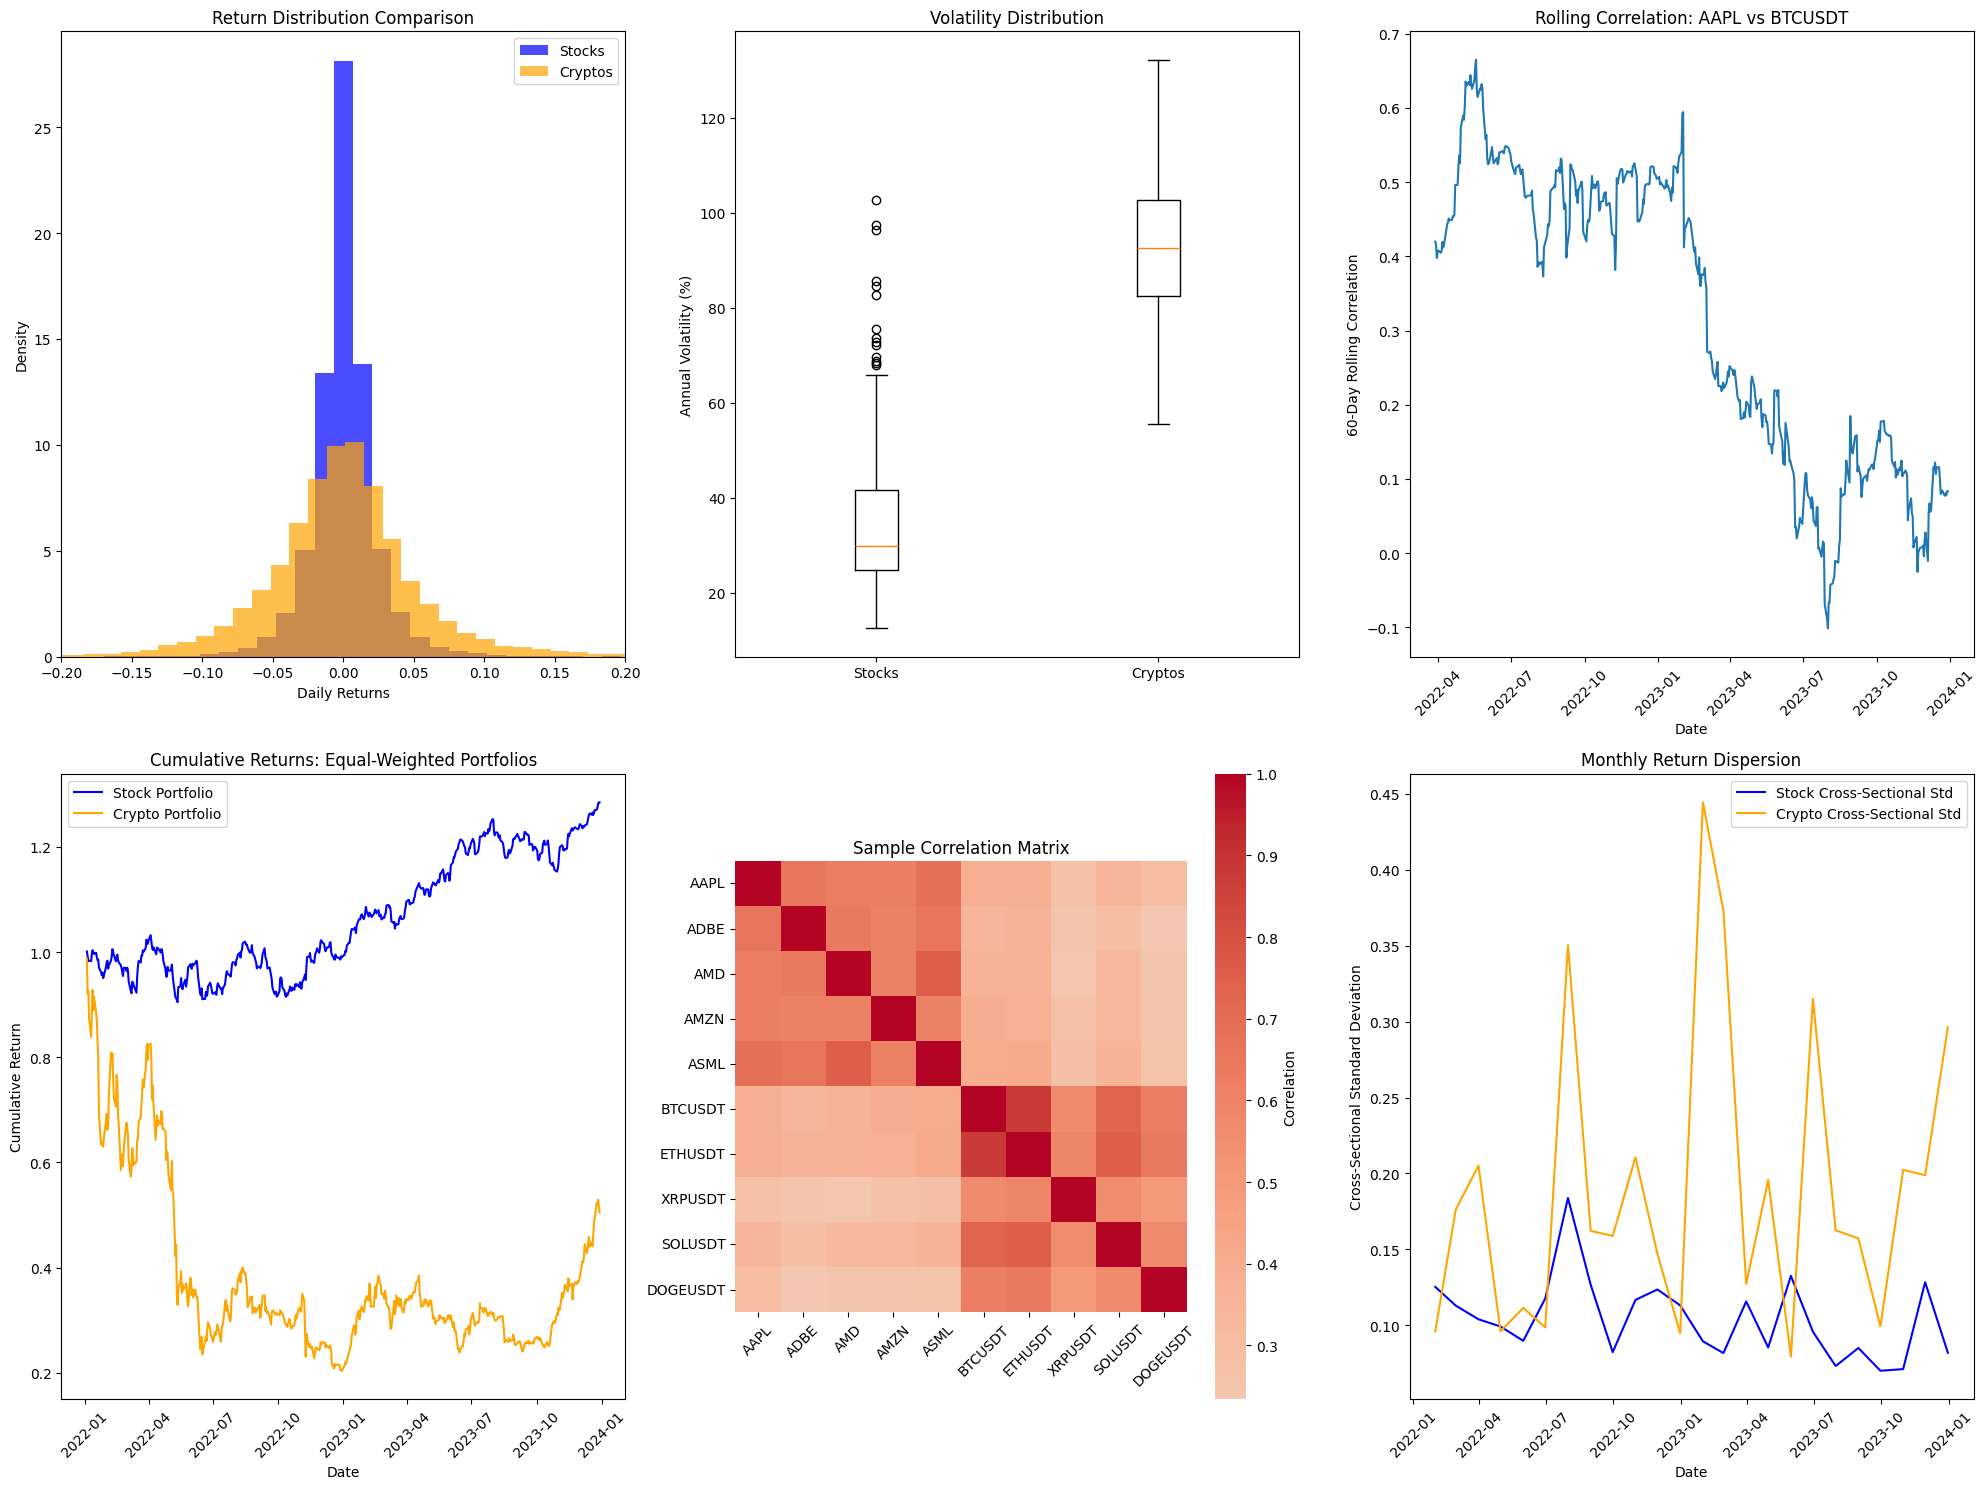

TypeError: 'NoneType' object is not subscriptable

In [11]:
#Main part data 2022-2023
from functions import join_stocks_crypto
df_all_stocks = pd.read_csv('stocks_data_FINAL.csv',index_col='Date')
df_all_stocks.index = pd.to_datetime(df_all_stocks.index)
df_all_stocks.index = df_all_stocks.index.strftime('%Y-%m-%d')

cryptos_df = pd.read_csv('cryptos_data_new.csv', index_col='timestamp')
joined_df = join_stocks_crypto(cryptos_df, df_all_stocks, mode = 'stocks_left')
joined_df.index = pd.to_datetime(joined_df.index)
returns_all = joined_df.pct_change().dropna()

# Define your asset lists
crypto_tickers = list(cryptos_df.columns)
stock_tickers = list(df_all_stocks.columns)

# Generate comprehensive descriptive statistics
desc_stats = generate_descriptive_statistics(
    df_prices=joined_df,
    crypto_list=crypto_tickers,
    stock_list=stock_tickers
)

# Create visualization plots
create_descriptive_plots(
    df_prices=joined_df,
    crypto_list=crypto_tickers,
    stock_list=stock_tickers,
    save_plots=True
)

# Save tables to CSV for inclusion in paper
#desc_stats['universe_summary'].to_csv('universe_summary.csv', index=False)
desc_stats['comparison_stats'].to_csv('return_characteristics.csv', index=False)
desc_stats['correlation_summary'].to_csv('correlation_analysis.csv', index=False)
desc_stats['normality_df'].to_csv('normality_tests.csv', index=False)
